# Limitatons of Modern Portfolio Theory
This will be an initial environment for brainstorming as well as numerical research for the Undergraduate dissertation.

In [60]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import scipy.optimize as sco
%matplotlib inline
plt.style.use('bmh')

In [48]:
#Going for a variety mix between asset classes
symbols = ['SPY', 'TLT', 'AGG', 'GLD']
noa = len(symbols)
data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.DataReader(sym, data_source='yahoo',
    end='2017-01-01')['Adj Close']
data.columns = symbols

In [49]:
data.head()

,SPY,TLT,AGG,GLD
Date,,,,
2010-01-04,97.788948,72.322465,84.791225,109.800003
2010-01-05,98.047805,72.789531,85.176976,109.699997
2010-01-06,98.116836,71.815139,85.127733,111.510002
2010-01-07,98.531016,71.935933,85.029242,110.820000
2010-01-08,98.858904,71.903721,85.078491,111.370003


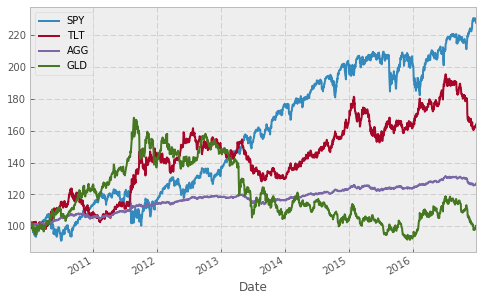

In [50]:
(data / data.ix[0] * 100).plot(figsize=(8, 5))

In [51]:
#Log-returns as mean variance suggests
rets = np.log(data / data.shift(1))

In [52]:
#initialize random weights
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.51270444,  0.09172882,  0.31469673,  0.08087001])

In [53]:
np.sum(rets.mean() * weights) * 252

0.07755346471524344

In [54]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.0055487427709903277

In [55]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.074489883682217733

In [56]:
#Monte Carlo simulation to generate random portfolio weight vectors
#and record resulting portfolio variance and return 
prets = []
pvols = []
for p in range (5000):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T,
    np.dot(rets.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

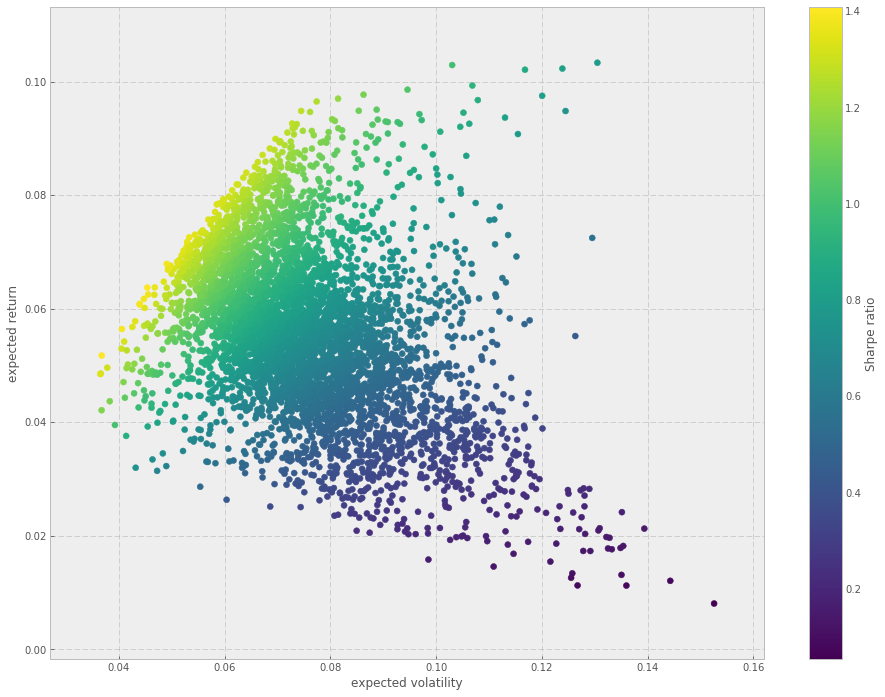

In [58]:
plt.figure(figsize=(16, 12))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [59]:
def statistics(weights):
    '''Returns portfolio statistics.
    Parameters
    ==========
    weights : array-like
    weights for different securities in portfolio
    Returns
    =======
    pret : float
    expected portfolio return
    pvol : float
    expected portfolio volatility
    pret / pvol : float
    Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [61]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [63]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [64]:
bnds = tuple((0, 1) for x in range(noa))

In [66]:
#optimise for Sharpe
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
        bounds=bnds, constraints=cons)

CPU times: user 60 ms, sys: 8 ms, total: 68 ms
Wall time: 71.6 ms


In [68]:
opts['x'].round(3)

array([ 0.158,  0.   ,  0.842,  0.   ])

In [70]:
statistics(opts['x']).round(3)

array([ 0.047,  0.032,  1.497])

In [72]:
#optimise for minimium variance
def min_func_variance(weights):
    return statistics(weights)[1] ** 2
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP', bounds=bnds,
        constraints=cons)
statistics(optv['x']).round(3)

array([ 0.042,  0.03 ,  1.404])

In [74]:
cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [75]:
def min_func_port(weights):
    return statistics(weights)[1]

In [77]:
%%time
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1./noa, ], method='SLSQP',
    bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 34.4 s, sys: 212 ms, total: 34.6 s
Wall time: 35.2 s


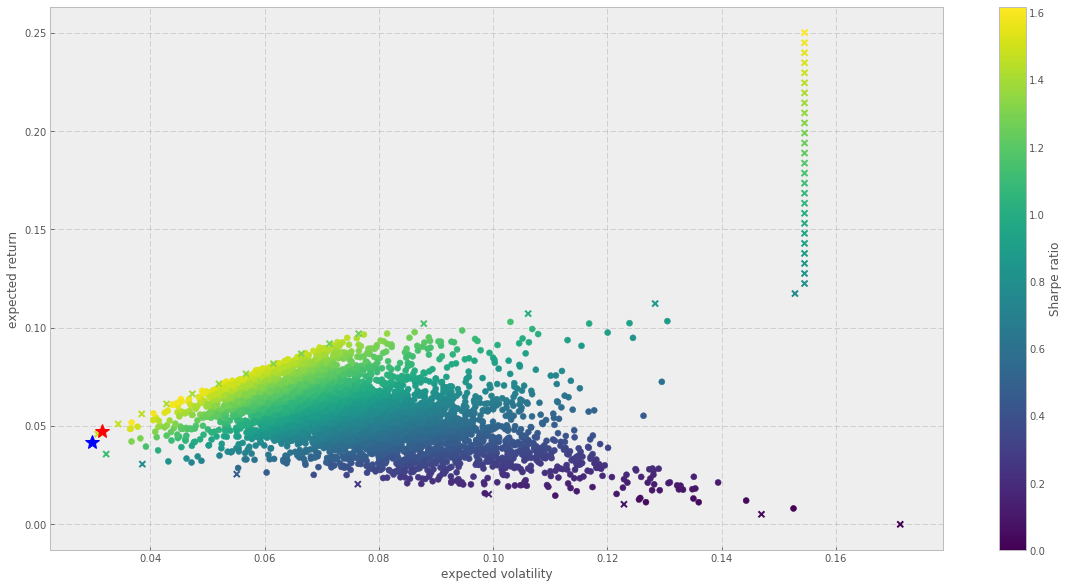

In [80]:
plt.figure(figsize=(20, 10))
plt.scatter(pvols, prets,
c=prets / pvols, marker='o')
# random portfolio composition
plt.scatter(tvols, trets,
c=trets / tvols, marker='x')
# efficient frontier
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
'r*', markersize=15.0)
# portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
'b*', markersize=15.0)
# minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')